# 🎮 **Steam Review Scraper**

Hecho por [Alejandro Barrionuevo Rosado](https://github.com/Alejandro-BR) y [Alvaro López Guerrero](https://github.com/Alvalogue72).

Repositorio: **[GitHub](https://github.com/Alejandro-BR/Steam-Review-Scraper)**

**Máster de FP en Inteligencia Artificial y Big Data**


## **Imagen general**

Extrae datos textuales de los comentarios de [Steam](https://store.steampowered.com/) y realiza un análisis de sentimientos y emociones, generando estadísticas cuantitativas y visualizaciones gráficas para su interpretación.

## **Importaciones**

In [1]:
import json
import re
import time
from datetime import datetime
from html import unescape

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup

from transformers import pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## **Obtención de los datos**

Para llevar a cabo el proyecto, hicimos una búsqueda de los datos de las dos formas posibles que ofrece **Steam**, mediante **web scraping** y usando su **API**.

Aunque para trabajar con los datos solo utilizaremos la **API**, ya que el **web scraping** es mucho más costoso y tarda cantidades de tiempo muy elevadas y en cambio, con la **API** podemos obtener más datos en mucho menos tiempo.

### **Call of Duty®: Black Ops 7**

Utilizaremos como ejemplo el juego: [**Call of Duty®: Black Ops 7**](https://store.steampowered.com/app/3606480/Call_of_Duty_Black_Ops_7/)

El cual salió el 14 de noviembre de 2025.

#### **Acerca de este juego:**

Con Call of Duty®: Black Ops 7, Treyarch y Raven Software traen la mayor entrega de Black Ops.

Corre el año 2035 y el mundo está al borde del caos, devastado por violentos conflictos y una guerra psicológica sin precedentes. David Mason lidera un equipo de élite en una misión encubierta en la extensa ciudad de Avalon. Allí descubren un plan sofisticado que no solo sumirá al mundo en el caos, sino que también los arrastrará a enfrentarse con con los fantasmas de su propio pasado.

Forma equipo o juega en solitario en una innovadora campaña cooperativa que redefine la experiencia de Black Ops.

El Multijugador llega pisando fuerte con 16 emocionantes mapas Multijugador 6c6 y dos mapas 20c20 en el lanzamiento. Domina un arsenal de tecnología puntera y supera a tus enemigos con un sistema de movimiento omnidireccional evolucionado.

En el legendario modo de Zombis por rondas de Treyarch, la pesadilla comienza donde termina la realidad. El equipo está atrapado en el corazón del éter oscuro y deberá abrirse paso por un extenso infierno cambiante en el mayor mapa de Zombis por rondas de la historia de Black Ops.

| Requisito         | Mínimo                                           | Recomendado                                    |
|------------------|-------------------------------------------------|-----------------------------------------------|
| Sistema Operativo | Windows® 10 64 Bit (última actualización)      | Windows® 11 64 Bit (última actualización)     |
| Procesador       | AMD Ryzen™ 5 1400 o Intel® Core™ i5-6600       | AMD Ryzen™ 5 1600X o Intel® Core™ i7-6700K   |
| Memoria RAM      | 8 GB                                            | 12 GB                                         |
| Tarjeta Gráfica  | AMD Radeon™ RX 470, NVIDIA® GTX 970/1060 o Intel® Arc™ A580 | AMD Radeon™ RX 6600XT, NVIDIA® RTX 3060 o Intel® Arc™ B580 |
| DirectX          | Versión 12                                      | Versión 12                                    |
| Conexión         | Banda ancha a Internet                          | Banda ancha a Internet                        |
| Almacenamiento   | SSD con 161 GB disponibles                      | SSD con 161 GB disponibles                    |



In [2]:
ID = 3606480  # Call of Duty®: Black Ops 7

### **API de Steam**

Hemos limitado el conjunto de datos a **1000 reseñas** para evitar tiempos de carga largos al descargar los comentarios.

Documentación: [API OFICIAL](https://partner.steamgames.com/doc/store/getreviews?l=spanish&language=english)

```python
url = f"https://store.steampowered.com/appreviews/{id}"
```





Logs personalizados para mostrar lo que va ocurriendo durante la obtención de los datos.

In [3]:
def log(message, level="INFO"):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{now}] [{level}] {message}")

Elimina cualquier etiqueta `HTML` presente en el texto.

In [4]:
def clean_html(text):
    text = unescape(text)
    text = re.sub(r"<.*?>", "", text)
    return text.strip()

Realiza un `GET` a la API de Steam usando los parámetros necesarios.

In [5]:
def fetch_reviews(id, cursor="*"):
    url = f"https://store.steampowered.com/appreviews/{id}"
    params = {
        "json": 1,
        "language": "spanish",
        "filter": "all",
        "review_type": "all",
        "purchase_type": "all",
        "num_per_page": 100,
        "cursor": cursor
    }
    try:
        r = requests.get(url, params=params, timeout=20)
        return r.json()
    except Exception as e:
        log(f"Error interpretando JSON: {e}", level="ERROR")
        return None

Construye nuestro `DataFrame`.

In [6]:
def scrape_to_dataframe(id, max = 10000):
    cursor = "*"
    total = 0
    data_list = []

    while True:
        log(f"Solicitando cursor: {cursor}")
        data = fetch_reviews(id, cursor)
        if not data or "success" not in data or data["success"] != 1:
            log("Error o respuesta inválida", level="ERROR")
            break

        reviews = data.get("reviews", [])
        if not reviews:
            log("No hay más reseñas. Fin.", level="DONE")
            break

        for r in reviews:
            item = {
                "recommended": r.get("voted_up"),
                "hours": r.get("author", {}).get("playtime_forever", 0) / 60,
                "timestamp_created": r.get("timestamp_created"),
                "timestamp_updated": r.get("timestamp_updated"),
                "review": clean_html(r.get("review", "")),
            }
            data_list.append(item)
            total += 1

            if total >= max:
                log(f"Límite de {max} reseñas alcanzado. Fin.", level="DONE")
                df = pd.DataFrame(data_list)
                return df

        log(f"Descargadas hasta ahora: {total}")
        cursor = data.get("cursor")
        if not cursor:
            log("Cursor vacío -> fin", level="DONE")
            break

        time.sleep(1.2)

    df = pd.DataFrame(data_list)
    log(f"FIN — Total reseñas en DataFrame: {len(df)}", level="DONE")
    return df

Obtenemos el dataframe con **3000 reseñas**, aunque en versiones anteriores teníamos 10.000.

Sin embargo debido al largo tiempo necesario para el análisis de sentimiento, se decidió reducirlo a 3000.

In [7]:
MAX_REVIEWS = 3000
reviews_df = scrape_to_dataframe(ID, MAX_REVIEWS)

[2025-12-02 17:41:10] [INFO] Solicitando cursor: *
[2025-12-02 17:41:10] [INFO] Descargadas hasta ahora: 38
[2025-12-02 17:41:12] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-12-02 17:41:12] [INFO] Descargadas hasta ahora: 76
[2025-12-02 17:41:13] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-12-02 17:41:14] [INFO] Descargadas hasta ahora: 114
[2025-12-02 17:41:15] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-12-02 17:41:15] [INFO] Descargadas hasta ahora: 152
[2025-12-02 17:41:16] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-12-02 17:41:17] [INFO] Descargadas hasta ahora: 190
[2025-12-02 17:41:18] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-12-02 17:41:18] [INFO] Descargadas hasta ahora: 228
[2025-12-02 17:41:19] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-12-02 17:41:20] [INFO] Descargadas hasta ahora: 266
[2025-12-02 17:41:21] [INFO] Solicitando cursor: AoIFQGBB0OAAAAB9nsOfBg==
[2025-12-02 17:41:21] [INFO

Podemos observar que disponemos de si el usuario recomienda o no el juego, las horas que jugó, las fechas y lo que nos interesa la `review`.

In [8]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recommended        3000 non-null   bool   
 1   hours              3000 non-null   float64
 2   timestamp_created  3000 non-null   int64  
 3   timestamp_updated  3000 non-null   int64  
 4   review             3000 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 96.8+ KB


In [9]:
reviews_df

,recommended,hours,timestamp_created,timestamp_updated,review
0,False,0.0,1763215663,1763456058,(Actuais todos como si comprara todos los cods...
1,False,0.0,1763263727,1763263727,"TREMENDO BODRIO, CALL OF DUTY BLACK OPS 6, NI ..."
2,False,0.0,1763400014,1763400014,Menudo mojón... Lo he comprado hace 1h y ya me...
3,False,0.0,1763266112,1763266112,"los zombies mi pasión, las mujeres negras mi p..."
4,False,0.0,1763784528,1763784528,Tiene SBMM cuando dijeron que lo habian quitad...
...,...,...,...,...,...
2995,False,0.0,1763244567,1763244567,shit game
2996,True,0.0,1763760749,1763760759,Only zombies is worth it..
2997,True,0.0,1763199088,1763199088,"No vale 80$, pero es un buen juego."
2998,True,0.0,1763342868,1763491940,"ta caro...si no,estaria bueno"


### **Web scraping de Steam**

Hemos limitado el conjunto de datos a **100 reseñas** para evitar tiempos de carga de varias horas al descargar los comentarios.

Este apartado es solo de prueba y no se utilizará en el resto del proyecto, ya que es menos eficiente.

In [10]:
session = requests.Session()

session.cookies.set("birthtime", "0")
session.cookies.set("lastagecheckage", "1-0-1900")
session.cookies.set("wants_mature_content", "1")

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36",
    "Accept-Language": "es-ES,es;q=0.9"
}

reviews_list = []
page = 1
MAX_REVIEWS_SCRAPING = 100

while True:
    print(f"[INFO] Scrapeando página {page}...")

    url = (
        f"https://steamcommunity.com/app/{ID}/reviews/"
        f"?p={page}&browsefilter=toprated&filterLanguage=spanish&l=spanish"
    )

    response = session.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")

    reviews_html = soup.find_all("div", class_="apphub_CardTextContent")

    if not reviews_html:
        print("[DONE] No hay más comentarios en esta página. Fin.")
        break

    for r in reviews_html:
        text = r.get_text(strip=True)
        if text:
            reviews_list.append(text)
            if len(reviews_list) >= MAX_REVIEWS_SCRAPING:
                print(f"[DONE] Límite de {MAX_REVIEWS_SCRAPING} comentarios alcanzado. Fin.")
                break

    if len(reviews_list) >= MAX_REVIEWS_SCRAPING:
        break

    page += 1
    time.sleep(1)

scraping_df = pd.DataFrame(reviews_list, columns=["review"])
print(f"\n[INFO] Total comentarios extraídos: {len(scraping_df)}")


[INFO] Scrapeando página 1...
[INFO] Scrapeando página 2...
[INFO] Scrapeando página 3...
[INFO] Scrapeando página 4...
[INFO] Scrapeando página 5...
[INFO] Scrapeando página 6...
[DONE] No hay más comentarios en esta página. Fin.

[INFO] Total comentarios extraídos: 55


Ya tenemos los datos guardados en el dataframe, pero podemos observar que no vienen completamente limpios.

In [11]:
scraping_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  55 non-null     object
dtypes: object(1)
memory usage: 572.0+ bytes


In [12]:
scraping_df

,review
0,Welcome to the neighborhood 🏘️ Step into the B...
1,"Hey, since bo6 season 6 is going to end soon, ..."
2,"This or BF6, what do u suggest, boys?"
3,Call of Duty: Black Ops 7 is available now and...
4,Call of Duty®: Black Ops 7is now live worldwid...
5,В данном разделе будет обсуждение о проблемах ...
6,I have the ultimate proof xD i played 3 lobbie...
7,Publicada el 27 de noviembreRefund because it’...
8,Publicada el 30 de noviembreEs una absoluta ve...
9,Publicada el 24 de noviembrenice


Limpiamos los comentarios eliminando la fecha de publicación inicial.

In [13]:
def clean_sc_text(x):
    # Patrón flexible
    x = re.sub(r"^Publicada\s*el\s*\d{1,2}\s*de\s*[\wáéíóúñ]+\s*(de\s*\d{4})?", "", x)
    return x.strip()

scraping_df["review"] = scraping_df["review"].apply(clean_sc_text)

In [14]:
print(scraping_df.head())

                                              review
0  Welcome to the neighborhood 🏘️ Step into the B...
1  Hey, since bo6 season 6 is going to end soon, ...
2              This or BF6, what do u suggest, boys?
3  Call of Duty: Black Ops 7 is available now and...
4  Call of Duty®: Black Ops 7is now live worldwid...


Aquí ya disponemos de los datos para utilizarlos, aunque como mencioné anteriormente, estos son solo de prueba y utilizaremos los otros.

In [15]:
scraping_df

,review
0,Welcome to the neighborhood 🏘️ Step into the B...
1,"Hey, since bo6 season 6 is going to end soon, ..."
2,"This or BF6, what do u suggest, boys?"
3,Call of Duty: Black Ops 7 is available now and...
4,Call of Duty®: Black Ops 7is now live worldwid...
5,В данном разделе будет обсуждение о проблемах ...
6,I have the ultimate proof xD i played 3 lobbie...
7,because it’s unfair that PC players can’t disa...
8,"una absoluta vergüenza, un desastre envuelto e..."
9,


## **Exploración y visualización de los datos**

Se realizará un estudio del dataset, mostrando gráficas de diferente tipo, observando valores nulos y realizando otros análisis.

In [16]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recommended        3000 non-null   bool   
 1   hours              3000 non-null   float64
 2   timestamp_created  3000 non-null   int64  
 3   timestamp_updated  3000 non-null   int64  
 4   review             3000 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 96.8+ KB


In [17]:
reviews_df.head()

,recommended,hours,timestamp_created,timestamp_updated,review
0,False,0.0,1763215663,1763456058,(Actuais todos como si comprara todos los cods...
1,False,0.0,1763263727,1763263727,"TREMENDO BODRIO, CALL OF DUTY BLACK OPS 6, NI ..."
2,False,0.0,1763400014,1763400014,Menudo mojón... Lo he comprado hace 1h y ya me...
3,False,0.0,1763266112,1763266112,"los zombies mi pasión, las mujeres negras mi p..."
4,False,0.0,1763784528,1763784528,Tiene SBMM cuando dijeron que lo habian quitad...


No deberían tener valores nulos ya que están obtenidos oficialmente, pero se comprobará por si acaso.

In [18]:
reviews_df.isnull().sum()

,0
recommended,0
hours,0
timestamp_created,0
timestamp_updated,0
review,0


Podemos observar claramente que está totalmente completo.

Pero comprobaremos que no haya valores inútiles, como cadenas vacías y números 0.

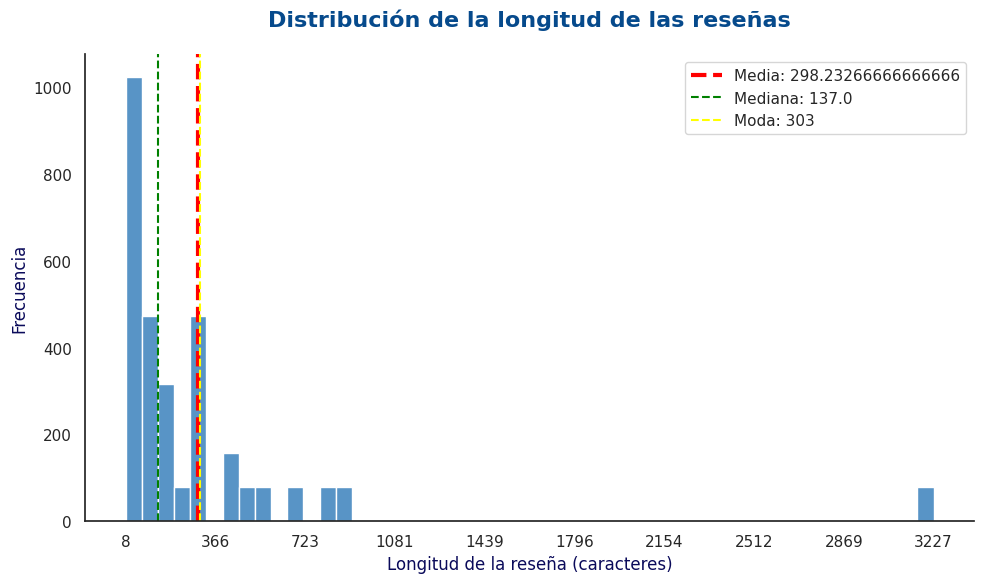

In [19]:
reviews_length = reviews_df["review"].astype(str).str.len()

mean_length = reviews_length.mean()
median_length = reviews_length.median()
mode_length = reviews_length.mode()[0]

sns.set_theme(style="white")
colors = sns.color_palette("Blues", n_colors=3)

plt.figure(figsize=(10, 6))

sns.histplot(
    x=reviews_length,
    bins=50,
    color=colors[2],
    edgecolor="white"
)

plt.axvline(mean_length, color="red", linestyle="--", linewidth=3, label=f"Media: {mean_length}")
plt.axvline(median_length, color="green", linestyle="--", linewidth=1.5, label=f"Mediana: {median_length}")
plt.axvline(mode_length, color="yellow", linestyle="--", linewidth=1.5, label=f"Moda: {mode_length}")

plt.title(
    "Distribución de la longitud de las reseñas",
    fontsize=16,
    color="#064A8C",
    pad=20,
    fontweight="bold"
)

plt.xlabel("Longitud de la reseña (caracteres)", fontsize=12, color="#0A0A5A")
plt.ylabel("Frecuencia", fontsize=12, color="#0A0A5A")

plt.xticks(
    ticks=np.linspace(reviews_length.min(), reviews_length.max(), 10)
)

plt.legend()
sns.despine()
plt.tight_layout()
plt.show()


Vemos que **no hay reseñas vacías** y que el mínimo de caracteres es 8 y el máximo es 3.227.

Ahora veremos en el caso de las horas jugadas al juego, que aunque vayamos a borrar este dato porque no nos interesa, es interesante de analizar.

/tmp/ipython-input-2860820429.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


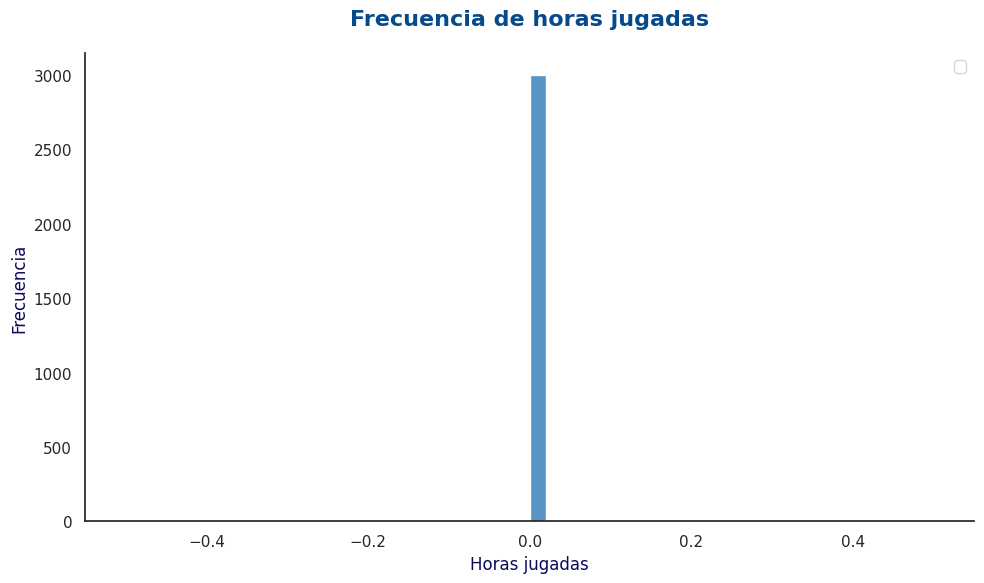

In [20]:
sns.set_theme(style="white")
colors = sns.color_palette("Blues", n_colors=3)

plt.figure(figsize=(10, 6))

sns.histplot(
    data=reviews_df,
    x="hours",
    bins=50,
    color=colors[2],
    edgecolor="white"
)

plt.title(
    "Frecuencia de horas jugadas",
    fontsize=16,
    color="#064A8C",
    pad=20,
    fontweight="bold"
)

plt.xlabel("Horas jugadas", fontsize=12, color="#0A0A5A")
plt.ylabel("Frecuencia", fontsize=12, color="#0A0A5A")

plt.legend()
sns.despine()
plt.tight_layout()
plt.show()


Vemos que esto se trata de un fallo en la API o en la obtención de los datos, porque siempre nos trajo **0,0 horas jugadas**, lo cual está obviamente mal. De todas formas, este dato no nos interesa para nada y lo vamos a borrar.

Vamos a ver si el usuario recomienda o no el juego. Este dato es importante porque podremos comparar a futuro el porcentaje de positivo y negativo respecto a si el usuario recomienda o no el juego, valores que deberían a priori ser similares.




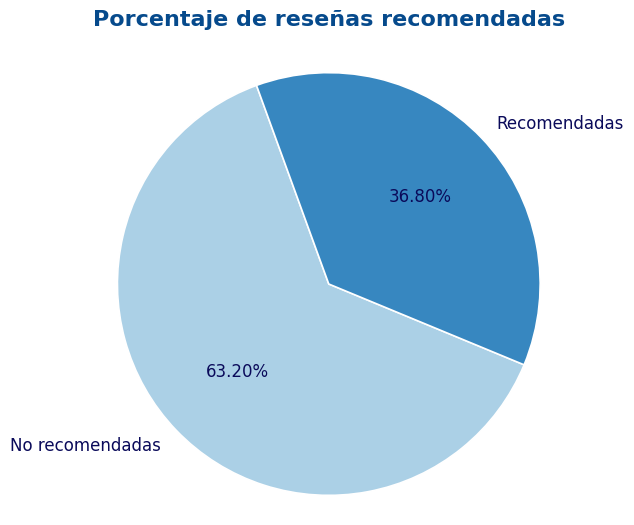

In [21]:
recommended_count = reviews_df['recommended'].sum()
not_recommended_count = len(reviews_df) - recommended_count

labels = ["No recomendadas", "Recomendadas"]
sizes = [not_recommended_count, recommended_count]

sns.set_theme(style="white")
colors = sns.color_palette("Blues", n_colors=2)

fig, ax = plt.subplots(figsize=(6, 6))

ax.pie(
    sizes,
    labels=labels,
    autopct="%1.2f%%",
    startangle=110,
    colors=colors,
    textprops={"color": "#0A0A5A", "fontsize": 12},
    wedgeprops={"linewidth": 1.2, "edgecolor": "white"}
)

ax.set_title(
    "Porcentaje de reseñas recomendadas",
    fontsize=16,
    color="#064A8C",
    pad=20,
    fontweight="bold"
)

ax.axis("equal")

plt.show()


Vemos que de **3000 usuarios**, solo el **36,80%** recomienda *Call of Duty®: Black Ops 7*, un porcentaje muy bajo de personas a las que les ha gustado este juego que salió recientemente.

*Estos dotos son de Diciembre de 2025.*

## **Preparación de los datos**

En este apartado, vamos a limpiar el dataset para dejarlo listo para analizar los comentarios.

Dejaremos solo las dos columnas que nos interesan la `review` y el `recommended`.

In [22]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recommended        3000 non-null   bool   
 1   hours              3000 non-null   float64
 2   timestamp_created  3000 non-null   int64  
 3   timestamp_updated  3000 non-null   int64  
 4   review             3000 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 96.8+ KB


In [23]:
drop_colums = ["hours", "timestamp_created", "timestamp_updated"]
reviews_df.drop(columns=drop_colums, inplace=True)

In [24]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   recommended  3000 non-null   bool  
 1   review       3000 non-null   object
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


Pasamos a minúsculas el texto de cada una de las reseñas, para que el clasificador trabaje mejor.

In [25]:
reviews_df["review"] = reviews_df["review"].str.lower()
reviews_df.head()

,recommended,review
0,False,(actuais todos como si comprara todos los cods...
1,False,"tremendo bodrio, call of duty black ops 6, ni ..."
2,False,menudo mojón... lo he comprado hace 1h y ya me...
3,False,"los zombies mi pasión, las mujeres negras mi p..."
4,False,tiene sbmm cuando dijeron que lo habian quitad...


El dataset ya podría usarse cómodamente para el análisis de sentimientos y para hacer gráficas respecto a la relación entre el recomendado y los sentimientos del texto.

## **Análisis de sentimientos**

Creamos la instancia del clasificador de texto, encargado del análisis del grado de sentimiento de las reseñas.

Las reseñas están en español, por ello utilizamos un modelo entrenado en este idioma.

In [26]:
classifier = pipeline("sentiment-analysis", model="finiteautomata/beto-sentiment-analysis")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


Aplicamos el modelo (clasificador) a nuestro dataframe.

Los modelos tipo BERT suelen tener un límite de 512 "tokens" (palabras/partes de palabras). Debemos asegurarnos de truncar el texto para que no dé error.

Al analizar el sentimiento de cada reseña, es decir cada registro, el clasificador devuelve:
* `label` → La clasificación categórica del sentimiento, que puede ser `POS`, `NEG` y `NEU`.
* `score` → un valor numérico entre $0$ y $1$ que representa la confianza o probabilidad que asigna el modelo a esa predicción.

*Nota: Este proceso puede durar unos minutos...*

In [27]:
def analyze_sentiment(text):
  result = classifier(text, truncation=True, max_length=512)[0]
  return result["label"], result["score"]

reviews_df["sentiment_label"], reviews_df["sentiment_score"] = zip(*reviews_df["review"].apply(analyze_sentiment))
reviews_df.head()

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,recommended,review,sentiment_label,sentiment_score
0,False,(actuais todos como si comprara todos los cods...,NEG,0.983914
1,False,"tremendo bodrio, call of duty black ops 6, ni ...",NEG,0.999181
2,False,menudo mojón... lo he comprado hace 1h y ya me...,NEG,0.998903
3,False,"los zombies mi pasión, las mujeres negras mi p...",NEG,0.996539
4,False,tiene sbmm cuando dijeron que lo habian quitad...,NEG,0.975739


In [28]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   recommended      3000 non-null   bool   
 1   review           3000 non-null   object 
 2   sentiment_label  3000 non-null   object 
 3   sentiment_score  3000 non-null   float64
dtypes: bool(1), float64(1), object(2)
memory usage: 73.4+ KB


### **Manejo de `NEU`**

El modelo clasifica ciertas reseñas como `NEU` (Neutral). Sin embargo, para evaluar el rendimiento del modelo frente a la variable objetivo binaria `recommended`. En estos casos asumimos el valor real proporcionado por el usuario en la columna `recommended`, es decir el voto real de la reseña.

In [29]:
def map_sentiment_smart(row):
    label = row["sentiment_label"]
    if label == "POS":
        return True
    elif label == "NEG":
        return False
    elif label == "NEU":
        return row["recommended"]

reviews_df["model_prediction_smart"] = reviews_df.apply(map_sentiment_smart, axis=1)

reviews_df.head()

,recommended,review,sentiment_label,sentiment_score,model_prediction_smart
0,False,(actuais todos como si comprara todos los cods...,NEG,0.983914,False
1,False,"tremendo bodrio, call of duty black ops 6, ni ...",NEG,0.999181,False
2,False,menudo mojón... lo he comprado hace 1h y ya me...,NEG,0.998903,False
3,False,"los zombies mi pasión, las mujeres negras mi p...",NEG,0.996539,False
4,False,tiene sbmm cuando dijeron que lo habian quitad...,NEG,0.975739,False


### **Voto real vs análisis de sentimiento**

Comparación entre el voto real que le dió cada usuario al juego y el análisis de sentimiento de la reseña. Para validar si el modelo logra replicar la tendencia y proporción de reseñas positivas y negativas que existen en los datos originales.

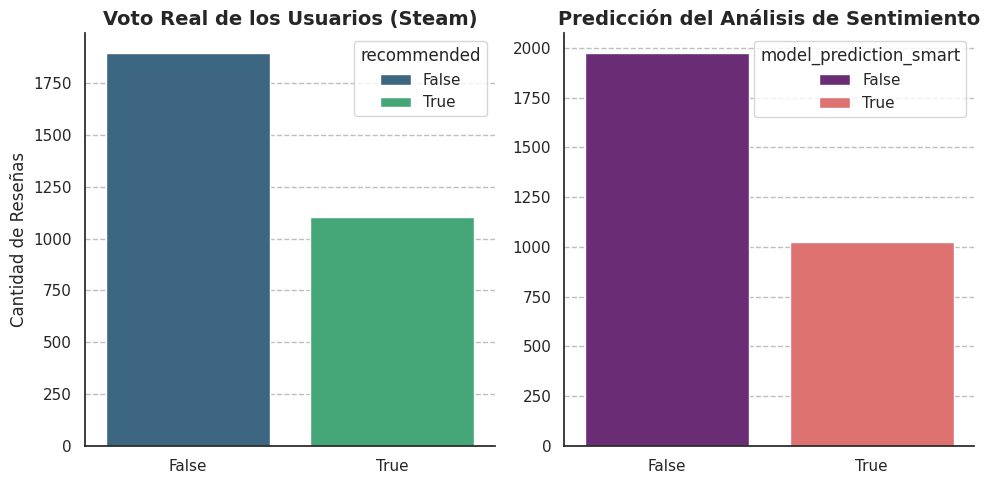

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(data=reviews_df, x="recommended", ax=axes[0], palette="viridis", order=[False, True], hue="recommended")
axes[0].set_title("Voto Real de los Usuarios (Steam)", fontsize=14, fontweight="bold")
axes[0].set_xlabel("")
axes[0].set_ylabel("Cantidad de Reseñas")

sns.countplot(data=reviews_df, x="model_prediction_smart", ax=axes[1], palette="magma", order=[False, True], hue="model_prediction_smart")
axes[1].set_title("Predicción del Análisis de Sentimiento", fontsize=14, fontweight="bold")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.5, color='gray', zorder=0)

sns.despine()
plt.tight_layout()
plt.show()

### **Matriz de confusión**

Para ver la precisión del modelo, representamos la matriz de confusión.

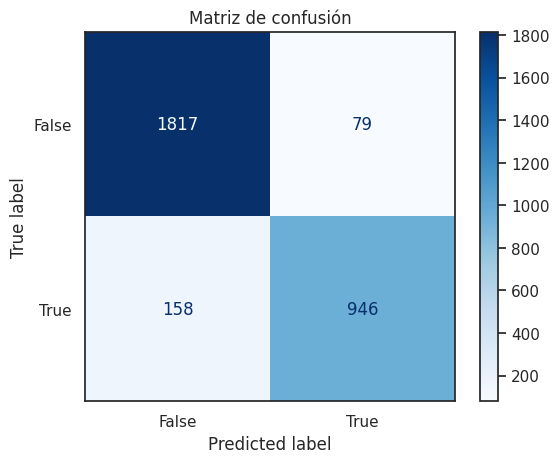

In [31]:
cm = confusion_matrix(reviews_df["recommended"], reviews_df["model_prediction_smart"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
disp.plot(cmap="Blues")
plt.title("Matriz de confusión")
plt.show()

### **Mensajes más positivos y negativos**

Mostramos para cada sentimiento, el mensaje con mayor `score`.

In [32]:
max_score = reviews_df.loc[reviews_df.groupby("sentiment_label")["sentiment_score"].idxmax()]
max_score

,recommended,review,sentiment_label,sentiment_score,model_prediction_smart
10,False,juego de mierda en medio de la ronda 31 de zom...,NEG,0.999424,False
26,False,"they lied about sbmm, this company hate the co...",NEU,0.998822,False
23,True,despues de 15h de juego la parte mas destacabl...,POS,0.998710,True


In [33]:
def mostrar(row):
    print("Sentiment:", row["sentiment_label"])
    print("Review:", row["review"])
    print("---")

list(map(mostrar, max_score.to_dict("records")))


Sentiment: NEG
Review: juego de mierda en medio de la ronda 31 de zombies casi por completar el easter egg se glitcheo la partida y a mi amigo y a mi nos saco que basura de juego
---
Sentiment: NEU
Review: they lied about sbmm, this company hate the costumers
---
Sentiment: POS
Review: despues de 15h de juego la parte mas destacable es que los zombis no me parecen malos, el multi bueno, no esta mal esta divertido, la campaña ni la voy a tocar, suficiente con lo que he visto, para mi es recomendable simplemente porque llevaba años sin jugar un cod y tenia ganas de darle otra vez a uno
---


[None, None, None]

Podemos observar que la palabra neutra se debe a que aunque Steam lo tenga como español, el mensaje se encuentra en inglés y por eso no entró como negativo.

## **Guardar el conjunto de datos**

Guardemos nuestro dataset después de haberlo creado a lo largo del proyecto.

In [34]:
reviews_df.to_csv("reviews_df.csv", index=False, encoding='utf-8')

> Solo Google Colab

In [35]:
# from google.colab import files

# files.download('reviews_df.csv')

## **Conclusiones**

Tras el procesamiento y análisis de las reseñas:
* El modelo de análisis de sentimiento ha logrado una precisión eficaz para predecir si un usuario que recomienda o no el juego corresponde con el sentimiento del texto de la reseña.
* Además los datos de sentimientos de los textos corroboran las estadísticas de Steam. La mayoría del lenguaje utilizado es negativo, al igual que el bajo porcentaje de recomendación.

Precisión del modelo (Accuracy): 92.10%


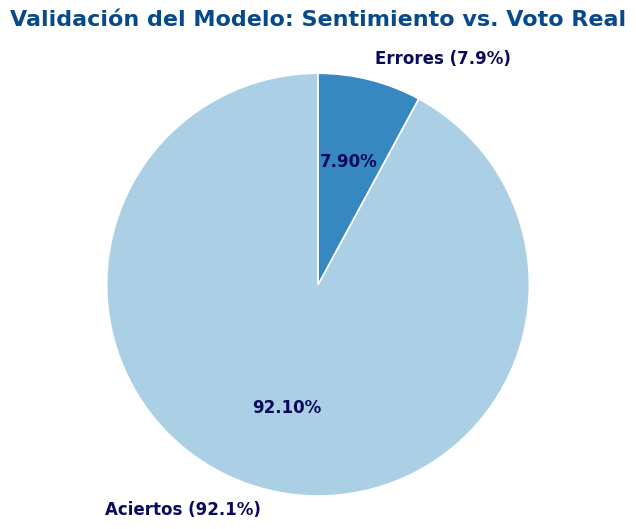

In [36]:
correctos = (reviews_df["recommended"] == reviews_df["model_prediction_smart"]).sum()
totales = len(reviews_df)
accuracy = (correctos / totales) * 100

print(f"Precisión del modelo (Accuracy): {accuracy:.2f}%")

incorrectos = totales - correctos
sizes = [correctos, incorrectos]
labels = [f"Aciertos ({accuracy:.1f}%)", f"Errores ({100-accuracy:.1f}%)"]

sns.set_theme(style="white")
colors = sns.color_palette("Blues", n_colors=2)

fig, ax = plt.subplots(figsize=(6, 6))

ax.pie(
    sizes,
    labels=labels,
    autopct="%1.2f%%",
    startangle=90,
    colors=colors,
    textprops={"color": "#0A0A5A", "fontsize": 12, "weight": "bold"},
    wedgeprops={"linewidth": 1.2, "edgecolor": "white"}
)

ax.set_title(
    "Validación del Modelo: Sentimiento vs. Voto Real",
    fontsize=16,
    color="#064A8C",
    pad=20,
    fontweight="bold"
)

ax.axis("equal")
plt.show()
